In [133]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
# import cv2 as cv
import os
import glob
import pandas as pd
import time
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
from scipy.spatial.transform import Rotation as R
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [4]:
df = pd.read_csv(r"C:\Users\archu\OneDrive\Desktop\sphere tracking\aerocoeff_df2.csv")
df.head()

,Time,X,Y,Z,Vx,Vy,Vz,Ax,Ay,Az,yaw,roll,pitch,C_D,C_L,C_z
0,55.08,6.897080,12.002743,2.616291,2.849603,-2.402818,3.518446,76.91427,-1.499417,30.788608,2.959416,-1.344324,-1.028525,0.432836,0.008438,0.173263
1,55.12,7.065294,12.026698,2.686268,3.442180,-1.395568,2.027872,76.91427,-1.499417,30.788608,3.055798,-1.244317,-1.009287,0.432836,0.008438,0.173263
2,55.16,7.171656,11.902388,2.831836,4.034758,-0.388318,0.537298,76.91427,-1.499417,30.788608,3.086846,-1.466701,-1.106401,0.432836,0.008438,0.173263
3,55.20,7.346494,11.884420,2.716885,4.534220,-0.072008,0.353039,76.91427,-1.499417,30.788608,3.145654,-1.446309,-1.163121,0.432836,0.008438,0.173263
4,55.24,7.563431,11.996219,2.708442,4.844475,-0.285297,0.716259,76.91427,-1.499417,30.788608,3.279278,-1.144457,-1.065323,0.432836,0.008438,0.173263


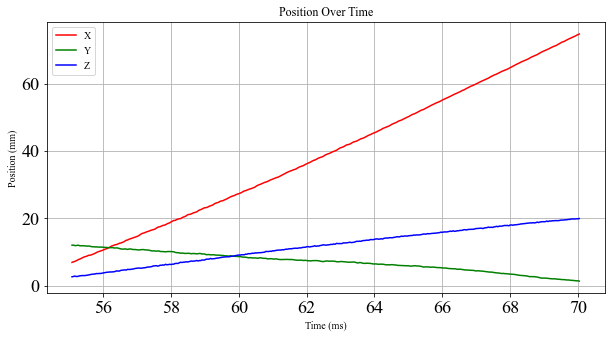

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['X'], label='X', color='r')
plt.plot(df['Time'], df['Y'], label='Y', color='g')
plt.plot(df['Time'], df['Z'], label='Z', color='b')
plt.title('Position Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Position (mm)')
plt.legend()
plt.grid(True)
plt.show()


## Linear Fit

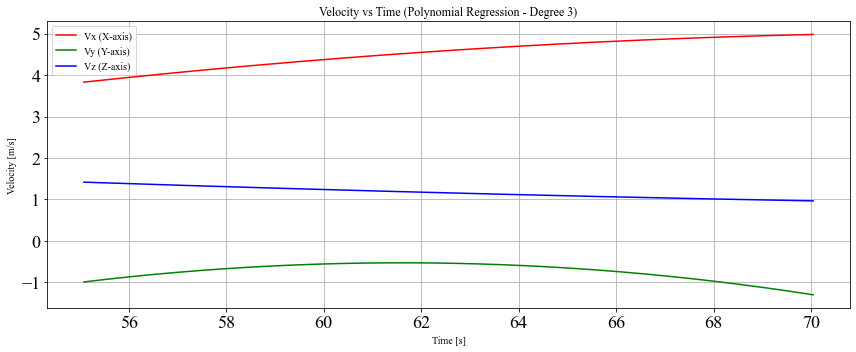

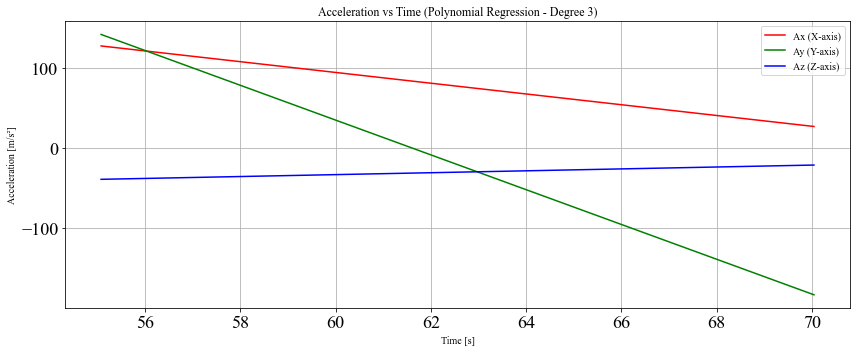

In [185]:
# Update regression functions for degree 3
def poly_velocity_deg3(df, col):
    model = np.polyfit(df['Time'], df[col], deg=3)
    poly = np.poly1d(model)
    velocity = np.polyder(poly, m=1)(df['Time'])
    return velocity

def poly_acceleration_deg3(df, col):
    model = np.polyfit(df['Time'], df[col], deg=3)
    poly = np.poly1d(model)
    acceleration = np.polyder(poly, m=2)(df['Time'])
    return acceleration

# Recalculate velocity and acceleration using degree 3
df['vx'] = poly_velocity_deg3(df, 'X')
df['vy'] = poly_velocity_deg3(df, 'Y')
df['vz'] = poly_velocity_deg3(df, 'Z')

df['ax'] = poly_acceleration_deg3(df, 'X')
df['ay'] = poly_acceleration_deg3(df, 'Y')
df['az'] = poly_acceleration_deg3(df, 'Z')

# Plot velocity after degree-3 polynomial fit
plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['vx'], label='Vx (X-axis)', color='r')
plt.plot(df['Time'], df['vy'], label='Vy (Y-axis)', color='g')
plt.plot(df['Time'], df['vz'], label='Vz (Z-axis)', color='b')
plt.title('Velocity vs Time (Polynomial Regression - Degree 3)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot acceleration after degree-3 polynomial fit
plt.figure(figsize=(12, 5))
plt.plot(df['Time'], df['ax']*1000, label='Ax (X-axis)', color='r')
plt.plot(df['Time'], df['ay']*1000, label='Ay (Y-axis)', color='g')
plt.plot(df['Time'], df['az']*1000, label='Az (Z-axis)', color='b')
plt.title('Acceleration vs Time (Polynomial Regression - Degree 3)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


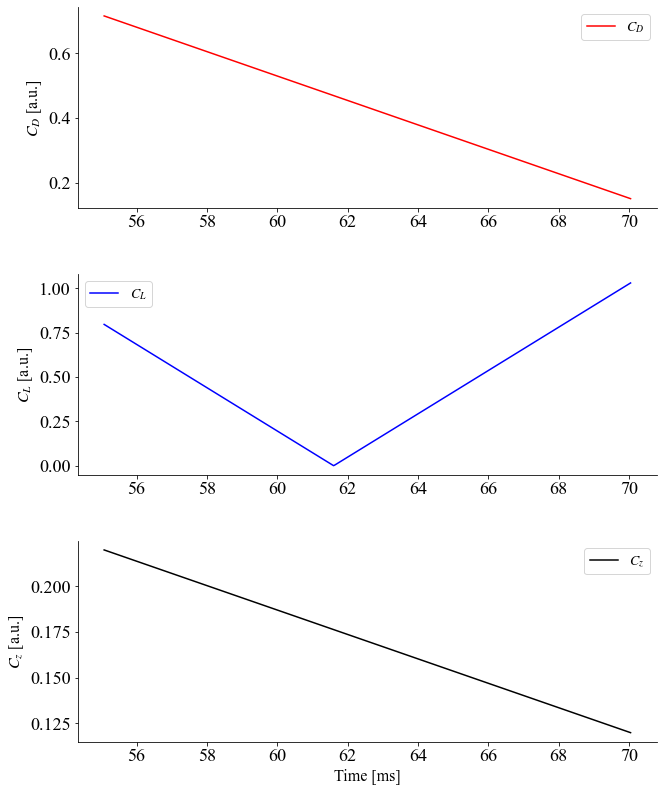

In [181]:
# Recalculate aerodynamic coefficients
m = 87.5 / 1000  # kg
r = 28.575 / 1000  # m
A = np.pi * r**2  # m^2
P = 0.024226295980244256 * 6894.76  # Pa
gamma = 1.4
M = 7.2
q_inf = 0.5 * P * gamma * M**2  # Pa

df['Cd'] = (m * np.abs(df['ax']*1000)) / (q_inf * A)
df['Cl'] = (m * np.abs(df['ay']*1000)) / (q_inf * A)
df['Cz'] = (m * np.abs(df['az']*1000)) / (q_inf * A)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.tight_layout(pad=5.0)

# Plot C_D
axes[0].plot(df.Time, df.Cd, 'r', label=r'$C_D$')
axes[0].set_ylabel(r'$C_D$ [a.u.]', fontsize=16)
axes[0].legend(fontsize=14)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

# Plot C_L
axes[1].plot(df.Time, df.Cl, 'b', label=r'$C_L$')
axes[1].set_ylabel(r'$C_L$ [a.u.]', fontsize=16)
axes[1].legend(fontsize=14)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Plot C_z
axes[2].plot(df.Time, df.Cz, 'k', label=r'$C_z$')
axes[2].set_xlabel('Time [ms]', fontsize=16)
axes[2].set_ylabel(r'$C_z$ [a.u.]', fontsize=16)
axes[2].legend(fontsize=14)
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].yaxis.set_ticks_position('left')
axes[2].xaxis.set_ticks_position('bottom')

plt.show()


## Differential

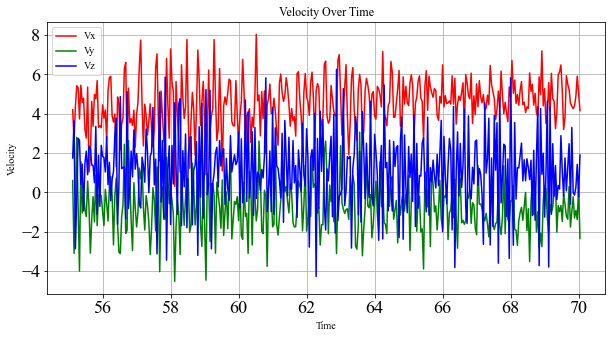

In [22]:
# Compute differences
dx = df['X'].diff()
dy = df['Y'].diff()
dz = df['Z'].diff()
dt = df['Time'].diff()

# Compute velocity components (v = dx/dt)
df['vx'] = dx / dt
df['vy'] = dy / dt
df['vz'] = dz / dt

# Optional: magnitude of velocity vector
# df['v_mag'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['vx'], label='Vx', color='r')
plt.plot(df['Time'], df['vy'], label='Vy', color='g')
plt.plot(df['Time'], df['vz'], label='Vz', color='b')
plt.title('Velocity Over Time')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.grid(True)
plt.show()


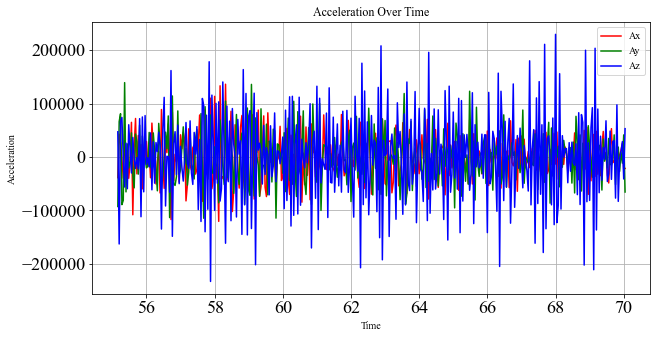

In [97]:
# Compute differences
dvx = df['vx'].diff()
dvy = df['vy'].diff()
dvz = df['vz'].diff()
dt = df['Time'].diff()

# Compute velocity components (v = dx/dt)
df['ax'] = dvx / dt
df['ay'] = dvy / dt
df['az'] = dvz / dt

# Optional: magnitude of velocity vector
# df['v_mag'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['ax']*1000, label='Ax', color='r')
plt.plot(df['Time'], df['ay']*1000, label='Ay', color='g')
plt.plot(df['Time'], df['az']*1000, label='Az', color='b')
plt.title('Acceleration Over Time')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()


## Polynomial Regression

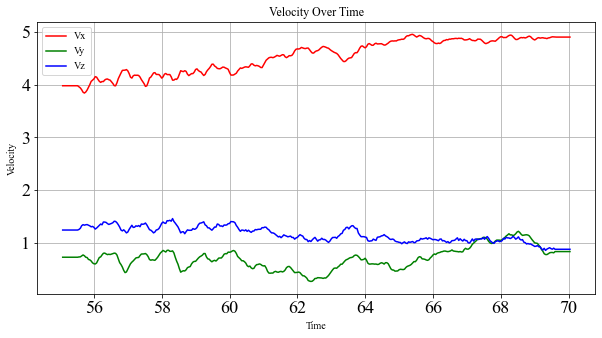

In [172]:
# Estimate the time step (assuming uniform sampling)
dt = df['Time'].iloc[1] - df['Time'].iloc[0]  # or use np.mean(df['Time'].diff())

# Apply Savitzky-Golay filter to compute first derivative (velocity)
window_length = 23  # Must be odd and <= len(df)
polyorder = 1       # Polynomial degree to fit

df['vx_savgol'] = savgol_filter(df['X'], window_length, polyorder, deriv=1, delta=dt)
df['vy_savgol'] = savgol_filter(df['Y'], window_length, polyorder, deriv=1, delta=dt)
df['vz_savgol'] = savgol_filter(df['Z'], window_length, polyorder, deriv=1, delta=dt)

plt.figure(figsize=(10, 5))
plt.plot(df['Time'], np.abs(df['vx_savgol']), label='Vx', color='r')
plt.plot(df['Time'], np.abs(df['vy_savgol']), label='Vy', color='g')
plt.plot(df['Time'], np.abs(df['vz_savgol']), label='Vz', color='b')
plt.title('Velocity Over Time')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.grid(True)
plt.show()


Estimated steady acceleration in l: 0.071278 m/s²
Estimated steady acceleration in l: -0.019881 m/s²
Estimated steady acceleration in l: -0.028351 m/s²


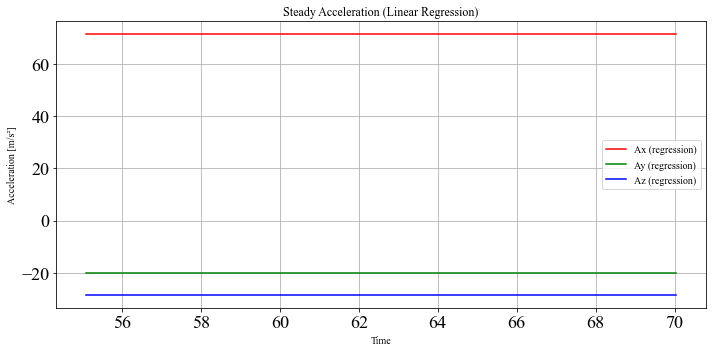

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Time as input (reshaped for sklearn)
t = df['Time'].values.reshape(-1, 1)

# Storage for acceleration
acc_dict = {}

# Estimate acceleration for each velocity component
for axis in ['vx_savgol', 'vy_savgol', 'vz_savgol']:
    v = df[axis].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(t, v)
    
    # The slope of velocity vs time is acceleration
    a = model.coef_[0][0]
    acc_dict[axis] = np.full_like(df['Time'], a)  # constant acceleration estimate

    print(f"Estimated steady acceleration in {axis[-1]}: {a:.6f} m/s²")

# Store in dataframe
df['ax_reg'] = acc_dict['vx_savgol']
df['ay_reg'] = acc_dict['vy_savgol']
df['az_reg'] = acc_dict['vz_savgol']

plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['ax_reg']*1000, label='Ax (regression)', color='red')
plt.plot(df['Time'], df['ay_reg']*1000, label='Ay (regression)', color='green')
plt.plot(df['Time'], df['az_reg']*1000, label='Az (regression)', color='blue')

plt.title('Steady Acceleration (Linear Regression)')
plt.xlabel('Time')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


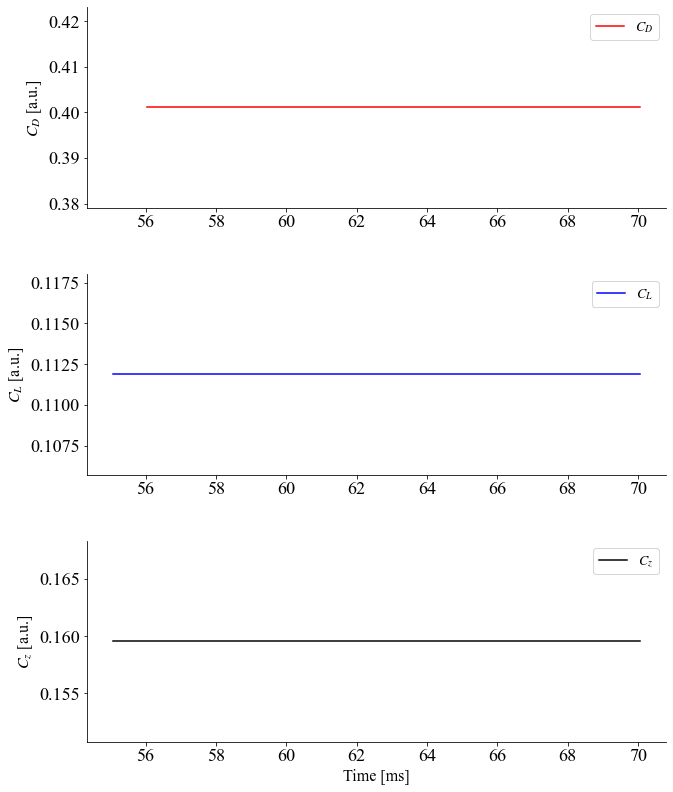

In [174]:
m = 87.5/1000 # Mass, kg
r = 28.575/1000 #Radius, m
P0 = 6894.76*120 # Stagnation pressure, pa
P = 0.024226295980244256*6894.76 #Static pressure, pa
gamma = 1.4
M = 7.2 #Mach Number
A = np.pi*(r**2) # Reference area, m^2
q_inf = (1/2)*P*gamma*(M**2)  # Stagnation/dynammic pressure of test, Pa
g = 9.81 # Acceleration due to gravity, m/s^2
U_inf = 886.33 # Freestream velocity, m/s
rho= 0.022053985550548307
I_yy = (2/5)*m*(r**2) # Moment of inertia about the pitching axis/center of mass, kgm^2

df['C_D'] = (m*np.abs(df.ax_reg*1000))/(q_inf*A)
df['C_L'] = (m*np.abs(df.ay_reg*1000))/(q_inf*A)
df['C_z'] = (m*np.abs(df.az_reg*1000))/(q_inf*A)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.tight_layout(pad=5.0)

# Plot C_D
axes[0].plot(df.Time[24:], df.C_D[24:], 'r', label=r'$C_D$')
axes[0].set_ylabel(r'$C_D$ [a.u.]', fontsize=16)
axes[0].legend(fontsize=14)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

# Plot C_L
axes[1].plot(df.Time, df.C_L, 'b', label=r'$C_L$')
axes[1].set_ylabel(r'$C_L$ [a.u.]', fontsize=16)
axes[1].legend(fontsize=14)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')

# Plot C_z
axes[2].plot(df.Time, df.C_z, 'k', label=r'$C_z$')
axes[2].set_xlabel('Time [ms]', fontsize=16)
axes[2].set_ylabel(r'$C_z$ [a.u.]', fontsize=16)
axes[2].legend(fontsize=14)
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].yaxis.set_ticks_position('left')
axes[2].xaxis.set_ticks_position('bottom')

plt.show()

In [132]:
np.mean(df.C_D)

0.8257544528339065

In [35]:
df[['Time','X','Y','Z','vx_savgol','vy_savgol','vz_savgol','ax_savgol','ay_savgol','az_savgol']]

,Time,X,Y,Z,vx_savgol,vy_savgol,vz_savgol,ax_savgol,ay_savgol,az_savgol
0,55.08,6.897080,12.002743,2.616291,4.016641,-0.726506,1.306370,0.075430,0.033742,0.017039
1,55.12,7.065294,12.026698,2.686268,4.016641,-0.726506,1.306370,0.075430,0.033742,0.017039
2,55.16,7.171656,11.902388,2.831836,4.016641,-0.726506,1.306370,0.075430,0.033742,0.017039
3,55.20,7.346494,11.884420,2.716885,4.016641,-0.726506,1.306370,0.075430,0.033742,0.017039
4,55.24,7.563431,11.996219,2.708442,4.016641,-0.726506,1.306370,0.075430,0.033742,0.017039
...,...,...,...,...,...,...,...,...,...,...
370,69.88,73.949346,1.501494,19.785047,4.892820,-0.935057,0.917777,0.002456,0.137794,-0.088051
371,69.92,74.145205,1.464532,19.795632,4.892820,-0.935057,0.917777,0.002456,0.137794,-0.088051
372,69.96,74.381722,1.409149,19.852432,4.892820,-0.935057,0.917777,0.002456,0.137794,-0.088051
373,70.00,74.582363,1.420078,19.843436,4.892820,-0.935057,0.917777,0.002456,0.137794,-0.088051


## Kalman Filter

In [129]:
# Example: Assume df has columns ['Time', 'X']
positions = df['X'].values
dt = df['Time'].iloc[1] - df['Time'].iloc[0]  # assume constant time step

# Initialize state: [position, velocity, acceleration]
x = np.zeros((3, 1))

# State transition matrix (constant acceleration)
A = np.array([
    [1, dt, 0.5 * dt**2],
    [0, 1, dt],
    [0, 0, 1]
])

# Measurement matrix (we only measure position)
H = np.array([[1, 0, 0]])

# Initial uncertainty
P = np.eye(3)

# Process noise (tune this if too noisy/smooth)
Q = np.array([
    [1e-6, 0, 0],
    [0, 1e-3, 0],
    [0, 0, 1e-2]
])

# Measurement noise (position measurement noise)
R = np.array([[1e-2]])

# Storage for estimates
estimates = []

for z in positions:
    # Prediction step
    x = A @ x
    P = A @ P @ A.T + Q

    # Measurement update
    z = np.array([[z]])  # actual measurement
    y = z - H @ x        # innovation
    S = H @ P @ H.T + R  # innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain

    x = x + K @ y
    P = (np.eye(3) - K @ H) @ P

    estimates.append(x.flatten())

# Convert to DataFrame
estimates = np.array(estimates)
df['X_kalman'] = estimates[:, 0]
df['vx_kalman'] = estimates[:, 1]
df['ax_kalman'] = estimates[:, 2]

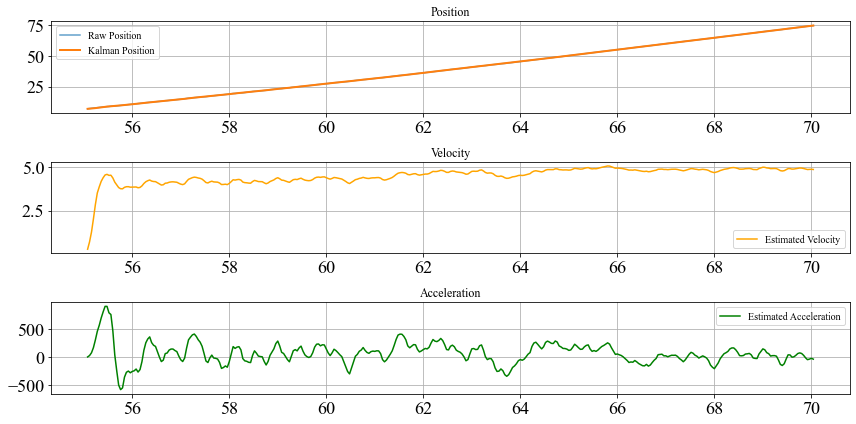

In [145]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(df['Time'], df['X'], label='Raw Position', alpha=0.5)
plt.plot(df['Time'], df['X_kalman'], label='Kalman Position', linewidth=2)
plt.legend(); plt.title('Position'); plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['Time'], df['vx_kalman'], label='Estimated Velocity', color='orange')
plt.legend(); plt.title('Velocity'); plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['Time'], df['ax_kalman']*1000, label='Estimated Acceleration', color='green')
plt.legend(); plt.title('Acceleration'); plt.grid(True)

plt.tight_layout()
plt.show()


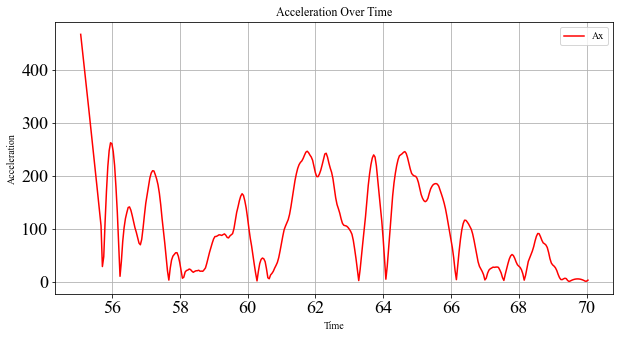

In [144]:
def moving_regression(y, x, window_size=11, order=1):
    smoothed = np.full_like(y, np.nan)
    half = window_size // 2
    
    for i in range(half, len(y) - half):
        x_window = x[i - half:i + half + 1].reshape(-1, 1)
        y_window = y[i - half:i + half + 1]
        
        model = LinearRegression()
        model.fit(x_window, y_window)
        smoothed[i] = model.predict([[x[i]]])[0]
    
    return smoothed
x = df['Time'].values
y = df['ax_kalman'].values

df['ax_smoothed'] = savgol_filter(df['ax_kalman'], window_length=31, polyorder=2)
# moving_regression(y, x, window_size=20, order=4)

plt.figure(figsize=(10, 5))
plt.plot(df['Time'], np.abs(df['ax_smoothed']*1000), label='Ax', color='r')

plt.title('Acceleration Over Time')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

## Linear regression vs Savitzsky Golay Filter with Tikhonovo Regularization for smoothing

In [ ]:
### START FROM HERE

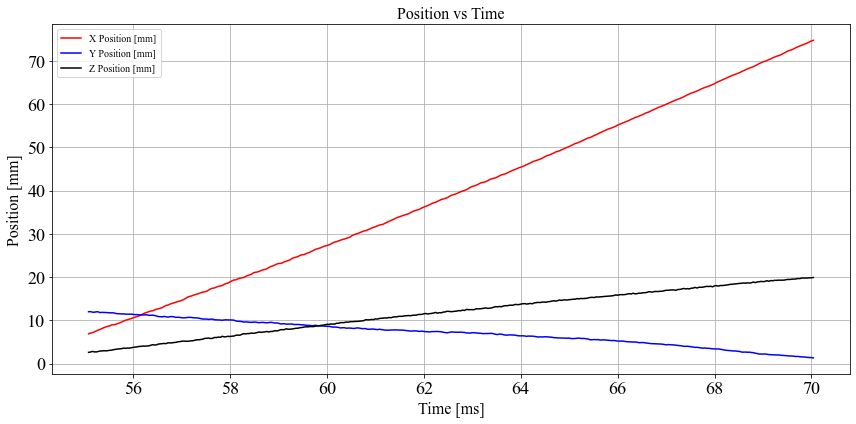

In [216]:
# Re-import necessary libraries after kernel reset
import pandas as pd
import matplotlib.pyplot as plt

# Reload the dataset
df = pd.read_csv(r"C:\Users\archu\OneDrive\Desktop\sphere tracking\aerocoeff_df2.csv")

# Convert time to seconds
time_s = df['Time']

# Plot X, Y, Z positions vs time
plt.figure(figsize=(12, 6))
plt.plot(time_s, df['X'],'r', label='X Position [mm]')
plt.plot(time_s, df['Y'], 'b', label='Y Position [mm]')
plt.plot(time_s, df['Z'], 'k', label='Z Position [mm]')
plt.title('Position vs Time', fontsize=16)
plt.xlabel('Time [ms]', fontsize=16)
plt.ylabel('Position [mm]', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Velocity and Acceleration using linear regression

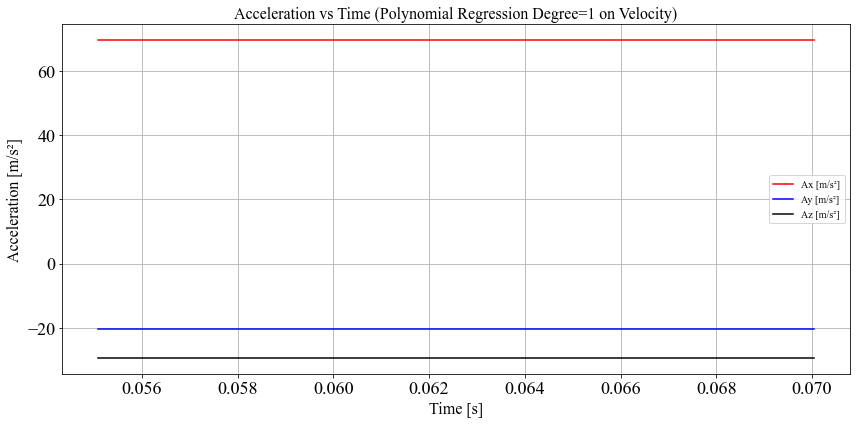

In [295]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Prepare time and velocity data for regression
T = time_s.values.reshape(-1, 1)
poly = PolynomialFeatures(degree=1)
T_poly1 = poly.fit_transform(T)

# Fit linear regression to velocity in each direction
vx_model = LinearRegression().fit(T_poly1, vx)
vy_model = LinearRegression().fit(T_poly1, vy)
vz_model = LinearRegression().fit(T_poly1, vz)

# Predict velocity and compute acceleration (constant)
vx_pred = vx_model.predict(T_poly1)
vy_pred = vy_model.predict(T_poly1)
vz_pred = vz_model.predict(T_poly1)

# Compute acceleration as derivative of linear fit (constant)
ax_poly1 = np.gradient(vx_pred, dt)
ay_poly1 = np.gradient(vy_pred, dt)
az_poly1 = np.gradient(vz_pred, dt)

# Plot acceleration
plt.figure(figsize=(12, 6))
plt.plot(time_s, ax_poly1,'r', label='Ax [m/s²]')
plt.plot(time_s, ay_poly1,'b', label='Ay [m/s²]')
plt.plot(time_s, az_poly1,'k', label='Az [m/s²]')
plt.title('Acceleration vs Time (Polynomial Regression Degree=1 on Velocity)', fontsize=16)
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Acceleration [m/s²]', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


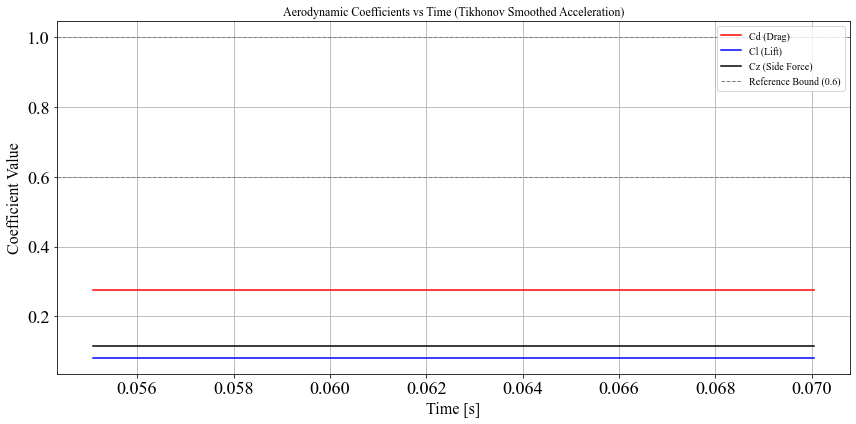

In [297]:
# Constants
m = 87.5 / 1000  # Mass in kg
r = 28.575 / 1000  # Radius in m
A = np.pi * r**2  # Reference area in m²
rho = 0.022053985550548307  # kg/m³
U_inf = 886.33  # Freestream velocity in m/s
q_inf = 0.5 * rho * U_inf**2  # Dynamic pressure

# Extract acceleration in X, Y, Z directions from smoothed Tikhonov results
# (Ax: Drag direction, Ay: Lift direction, Az: Side force direction)

Cd = (m * np.abs(ax_poly1)) / (q_inf * A)
Cl = (m * np.abs(ay_poly1)) / (q_inf * A)
Cz = (m * np.abs(az_poly1)) / (q_inf * A)

# Plot all three coefficients
plt.figure(figsize=(12, 6))
plt.plot(time_s, Cd, label='Cd (Drag)', color='red')
plt.plot(time_s, Cl, label='Cl (Lift)', color='blue')
plt.plot(time_s, Cz, label='Cz (Side Force)', color='black')
plt.axhline(0.6, color='gray', linestyle='--', linewidth=1, label='Reference Bound (0.6)')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title('Aerodynamic Coefficients vs Time (Tikhonov Smoothed Acceleration)')
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [282]:
# Compute mean values of smoothed Cd, Cl, Cz
Cd_mean = np.mean(Cd)
Cl_mean = np.mean(Cl)
Cz_mean = np.mean(Cz)

Cd_mean, Cl_mean, Cz_mean

(0.27427510494198487, 0.08082060336809471, 0.11586646785567901)

### Velocity using Savitzky-Golay filter

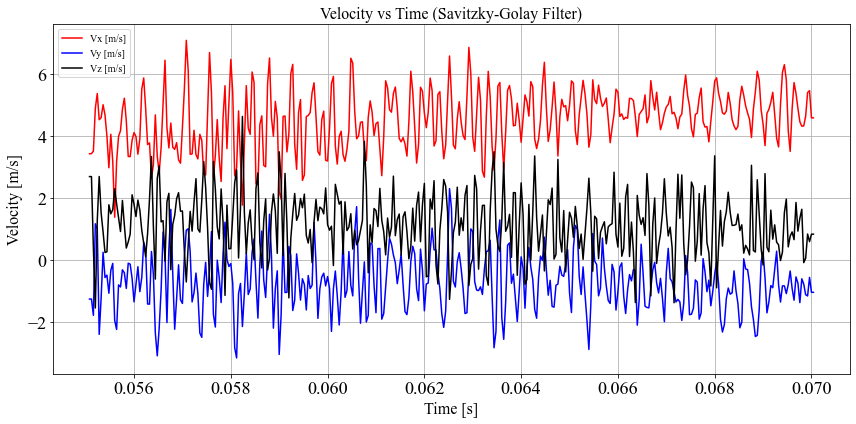

In [279]:
from scipy.signal import savgol_filter

# Convert position from mm to meters
x_m = df['X'] / 1000.0
y_m = df['Y'] / 1000.0
z_m = df['Z'] / 1000.0

# Time in seconds
time_s = df['Time'] / 1000.0
dt = np.mean(np.diff(time_s))

# Apply Savitzky-Golay filter to compute velocity (1st derivative)
window_length = 3  # needs to be odd
polyorder = 1

vx = savgol_filter(x_m, window_length, polyorder, deriv=1, delta=dt)
vy = savgol_filter(y_m, window_length, polyorder, deriv=1, delta=dt)
vz = savgol_filter(z_m, window_length, polyorder, deriv=1, delta=dt)

# Plot velocities
plt.figure(figsize=(12, 6))
plt.plot(time_s, vx,'r', label='Vx [m/s]')
plt.plot(time_s, vy,'b', label='Vy [m/s]')
plt.plot(time_s, vz,'k', label='Vz [m/s]')
plt.title('Velocity vs Time (Savitzky-Golay Filter)', fontsize=16)
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Velocity [m/s]', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


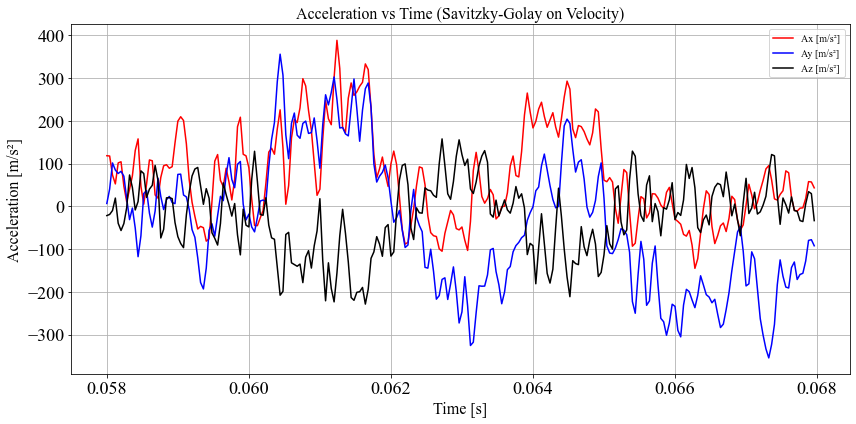

In [285]:
# Compute acceleration using Savitzky-Golay (1st derivative of velocity)
window_length_acc = 101  # moderately smooth window for acceleration
polyorder_acc = 3

ax_savgol = savgol_filter(vx, window_length_acc, polyorder_acc, deriv=1, delta=dt)
ay_savgol = savgol_filter(vy, window_length_acc, polyorder_acc, deriv=1, delta=dt)
az_savgol = savgol_filter(vz, window_length_acc, polyorder_acc, deriv=1, delta=dt)

# Plot acceleration
plt.figure(figsize=(12, 6))
plt.plot(time_s[73:323], ax_savgol[73:323],'r', label='Ax [m/s²]')
plt.plot(time_s[73:323], ay_savgol[73:323],'b', label='Ay [m/s²]')
plt.plot(time_s[73:323], az_savgol[73:323],'k', label='Az [m/s²]')
plt.title('Acceleration vs Time (Savitzky-Golay on Velocity)', fontsize=16)
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Acceleration [m/s²]', fontsize=16)
# plt.xlim(0.056,0.068)
# plt.ylim(-400,400)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


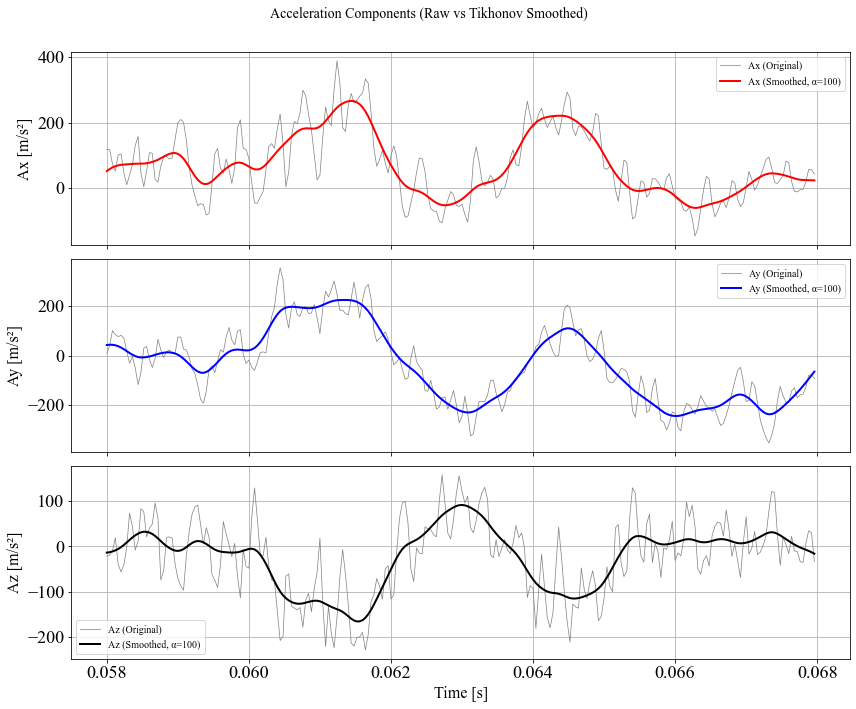

In [292]:
# Redefine the Tikhonov smoothing function
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve

def tikhonov_smooth_signal(y, alpha=10.0):
    """
    Tikhonov smoothing: solves min_x ||x - y||^2 + alpha * ||D2 x||^2
    where D2 is the second derivative matrix.
    """
    n = len(y)
    e = np.ones(n)
    D2 = diags([e, -2 * e, e], offsets=[-1, 0, 1], shape=(n, n))
    D2 = D2.tocsc()
    I = eye(n, format='csc')
    A = I + alpha * (D2.T @ D2)
    x_smooth = spsolve(A, y)
    return x_smooth

# Re-apply Tikhonov smoothing to acceleration with alpha = 100
ax_savgol_tikh = tikhonov_smooth_signal(ax_savgol, alpha=200.0)
ay_savgol_tikh = tikhonov_smooth_signal(ay_savgol, alpha=200.0)
az_savgol_tikh = tikhonov_smooth_signal(az_savgol, alpha=200.0)

# Plot each acceleration component in its own subplot with raw and smoothed curves

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Ax
axs[0].plot(time_s[73:323], ax_savgol[73:323], label='Ax (Original)', color='gray', linewidth=0.7)
axs[0].plot(time_s[73:323], ax_savgol_tikh[73:323], label='Ax (Smoothed, α=100)', color='red', linewidth=2)
axs[0].set_ylabel('Ax [m/s²]', fontsize=16)
axs[0].legend()
axs[0].grid(True)

# Ay
axs[1].plot(time_s[73:323], ay_savgol[73:323], label='Ay (Original)', color='gray', linewidth=0.7)
axs[1].plot(time_s[73:323], ay_savgol_tikh[73:323], label='Ay (Smoothed, α=100)', color='blue', linewidth=2)
axs[1].set_ylabel('Ay [m/s²]', fontsize=16)
axs[1].legend()
axs[1].grid(True)

# Az
axs[2].plot(time_s[73:323], az_savgol[73:323], label='Az (Original)', color='gray', linewidth=0.7)
axs[2].plot(time_s[73:323], az_savgol_tikh[73:323], label='Az (Smoothed, α=100)', color='black', linewidth=2)
axs[2].set_ylabel('Az [m/s²]', fontsize=16)
axs[2].set_xlabel('Time [s]', fontsize=16)
axs[2].legend()
axs[2].grid(True)

fig.suptitle('Acceleration Components (Raw vs Tikhonov Smoothed)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


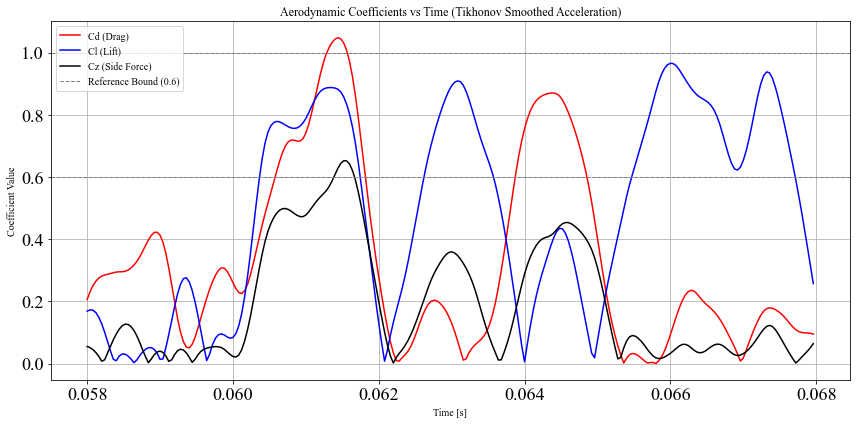

In [287]:
# Constants
m = 87.5 / 1000  # Mass in kg
r = 28.575 / 1000  # Radius in m
A = np.pi * r**2  # Reference area in m²
rho = 0.022053985550548307  # kg/m³
U_inf = 886.33  # Freestream velocity in m/s
q_inf = 0.5 * rho * U_inf**2  # Dynamic pressure

# Extract acceleration in X, Y, Z directions from smoothed Tikhonov results
# (Ax: Drag direction, Ay: Lift direction, Az: Side force direction)

Cd = (m * np.abs(ax_savgol_tikh)) / (q_inf * A)
Cl = (m * np.abs(ay_savgol_tikh)) / (q_inf * A)
Cz = (m * np.abs(az_savgol_tikh)) / (q_inf * A)

# Plot all three coefficients
plt.figure(figsize=(12, 6))
plt.plot(time_s[73:323], Cd[73:323], label='Cd (Drag)', color='red')
plt.plot(time_s[73:323], Cl[73:323], label='Cl (Lift)', color='blue')
plt.plot(time_s[73:323], Cz[73:323], label='Cz (Side Force)', color='black')
plt.axhline(0.6, color='gray', linestyle='--', linewidth=1, label='Reference Bound (0.6)')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title('Aerodynamic Coefficients vs Time (Tikhonov Smoothed Acceleration)')
plt.xlabel('Time [s]')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


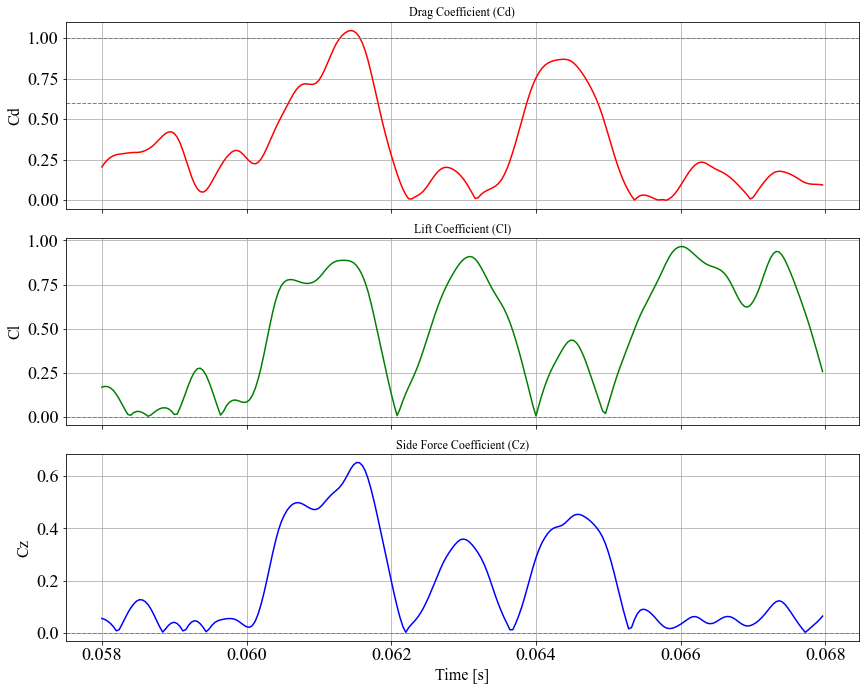

In [294]:
# Plot Cd, Cl, Cz in separate subplots

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Cd
axs[0].plot(time_s[73:323], Cd[73:323], color='red')
axs[0].axhline(0.6, color='gray', linestyle='--', linewidth=1)
axs[0].axhline(1.0, color='gray', linestyle='--', linewidth=1)
axs[0].set_ylabel('Cd', fontsize=16)
axs[0].set_title('Drag Coefficient (Cd)')
axs[0].grid(True)

# Cl
axs[1].plot(time_s[73:323], Cl[73:323], color='green')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[1].set_ylabel('Cl',fontsize=16)
axs[1].set_title('Lift Coefficient (Cl)')
axs[1].grid(True)

# Cz
axs[2].plot(time_s[73:323], Cz[73:323], color='blue')
axs[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[2].set_ylabel('Cz',fontsize=16)
axs[2].set_title('Side Force Coefficient (Cz)')
axs[2].set_xlabel('Time [s]',fontsize=16)
axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


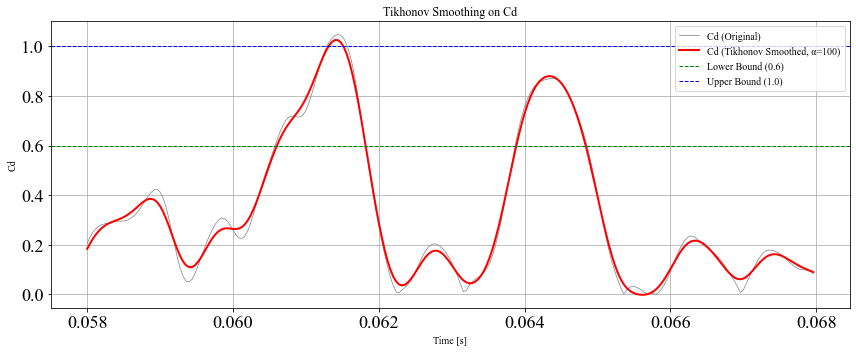

In [289]:
# Apply Tikhonov smoothing to the Cd curve directly
Cd_tikh = tikhonov_smooth_signal(Cd, alpha=100.0)

# Plot original and smoothed Cd
plt.figure(figsize=(12, 5))
plt.plot(time_s[73:323], Cd[73:323], label='Cd (Original)', color='gray', linewidth=0.7)
plt.plot(time_s[73:323], Cd_tikh[73:323], label='Cd (Tikhonov Smoothed, α=100)', color='red', linewidth=2)
plt.axhline(0.6, color='green', linestyle='--', linewidth=1, label='Lower Bound (0.6)')
plt.axhline(1.0, color='blue', linestyle='--', linewidth=1, label='Upper Bound (1.0)')
plt.title('Tikhonov Smoothing on Cd')
plt.xlabel('Time [s]')
plt.ylabel('Cd')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [290]:
# Compute mean values of smoothed Cd, Cl, Cz
Cd_mean = np.mean(Cd[73:323])
Cl_mean = np.mean(Cl[73:323])
Cz_mean = np.mean(Cz[73:323])

Cd_mean, Cl_mean, Cz_mean


(0.33362665102782824, 0.4879728525376518, 0.18933812457332017)